In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import pandas as pd
#https://developers.google.com/machine-learning/crash-course/reducing-loss/stochastic-gradient-descent

### Funkcje pomocnicze do algorytmów

In [19]:
import copy


def softmax_lasso(alpha,beta):
    
    #if beta > alpha:
    #    return beta - alpha
    b = copy.copy(beta)
    
    if np.any(b >alpha):
        b[b > alpha] = b[b > alpha] - alpha
    #elif beta < -alpha:
    #    return beta + alpha
    if np.any(b < (-alpha)):
        b[b < -alpha] = b[b < -alpha] + alpha
    #else:
    #    return 0
    if np.any((b > - alpha)&(b < alpha)):
        b[(b > - alpha)&(b < alpha)]  = 0
    
    return b


def grad_lasso(X,y,alpha,beta):
    n = X.shape[0]
    ols = -2 * X.T @ (y - X @ beta) /n
    soft = softmax_lasso(alpha,beta) 
    return ols + soft


def loss_function(X,y,beta,alpha):
    return np.sum((y - X @ beta)**2)/X.shape[0] + alpha * np.sum(abs(beta))

def square_grad(X,y,w):
    return X.T @ (X @ w - y)

### Dane na których porównuje efektywność algorytmu 

In [21]:
alpha = 0.5
dim = 30
N = 100
np.random.seed(50)
beta = np.random.randn(30)
w = np.random.randn(30)
X =np.random.multivariate_normal([0.0]*dim, np.eye(dim), size = N)
y = X @ w

### Znaleziony algorytm na kagglu opierający się tylko na pochodnych i soft-thresholding, nieskuteczny dla dużych danych
https://www.kaggle.com/residentmario/soft-thresholding-with-lasso-regression

In [5]:
def kaggle_lasso(X,y,beta,alpha,lr):

#   lr = 0.1
    loss = []
    for iter in range(100):
        #print(iter,"\n")
        loss.append(loss_function(X,y,beta,alpha))
        n = X.shape[0]
        ols = -2 * X.T @ (y - X @ beta) /n
        soft = softmax_lasso(alpha*lr,beta) 
    
        grad = soft + ols
        beta = beta - lr * grad

        if iter % 50 == 0:
            print(f"Loss of the function {loss_function(X,y,beta,alpha)}")
    

    plt.plot(np.arange(len(loss)),loss,'g',linewidth = 2, label = 'Kaggle function')
    plt.legend(prop={'size':12})
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    
    return loss

### Proximate gradient

In [6]:
def proximate_grad(X,y,beta,alpha,lr):

    #lr= 0.0001
    loss_prox = []

    for iter in range(100):
        #print(iter,"\n")
        loss = loss_function(X,y,beta,alpha)
        beta = beta - lr * square_grad(X,y,beta)
        beta = softmax_lasso(alpha*lr,beta)
        loss_prox.append(loss)
    
    if iter % 2 == 0:
        print(f"Loss of the function {loss}")


    #plt.semilogy(np.arange(len(loss_prox)),loss_prox,'m',linewidth = 2, label = 'Prox function')
    plt.plot(np.arange(len(loss_prox)),loss_prox,'m',linewidth = 2, label = 'Prox function')
    plt.legend(prop={'size':12})
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    
    return loss_prox

### Z przyspieszeniem Nesterova

In [7]:
def Nesterov(X,y,beta,alpha,lr):

    nest_loss = []

    #lr = 0.00015


    copy_beta = beta
    for iter in range(100):
        #print(iter,"\n")
        loss = loss_function(X,y,beta,alpha)
        nest_loss.append(loss)
    
        beta_prev = beta
        beta = copy_beta - lr*square_grad(X,y,copy_beta)
        beta = softmax_lasso(alpha*lr,beta)
        copy_beta  = beta + iter/(iter+3) * (beta - beta_prev)
    
        if iter % 10 == 0:
            print(f"Loss of the function {loss}")
    
    

    plt.plot(np.arange(len(nest_loss)),nest_loss,'b',linewidth = 2, label = 'Nesterov acceleration')
    plt.legend(prop={'size':12})
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    
    return nest_loss


In [65]:
#def Sthresh(x, gamma):
  #  return np.sign(x)*np.maximum(0, abs(x)-gamma/2.0)

### ADMM

In [79]:
def ADMM(X,y,beta,alpha,rho,max_iter = 10):
    
    m,n = X.shape

    #w,v  = np.linalg.eig(X.T @ X)
    u = np.array([0]*n)
    zhat = np.array([0]*n)

# coeficients 
    #alpha = 0.5
    #rho = 0.1 #1/abs(w).max()


#precomputing

    left_beta = np.linalg.inv(X.T @ X + rho*np.identity(n))
    #left_beta.shape

    Xty = X.T @ y 
    #Xty.shape

    admm_loss = []
    admm_loss.append(loss_function(X,y,beta,alpha))
    for i in range(max_iter):
        
        loss = loss_function(X,y,zhat,alpha)
        if i % 10 == 0:
            print(f"Loss of the function {loss}")
        admm_loss.append(loss)

        "x minimisation step via posterier OLS"
        beta = left_beta @ (Xty + rho*(zhat - u))

        "z minimisation via soft-thresholding"
        zhat =Sthresh(beta + u, alpha*rho) #softmax_lasso(alpha/rho,beta + u )#Sthresh(beta + u, alpha*rho)
       # softmax_lasso(alpha/rho,beta + u ) #Sthresh(beta + u, alpha/rho)

        "mulitplier update"
        u = u + beta - zhat
        



    plt.semilogy(np.arange(len(admm_loss)),admm_loss,'r--',linewidth = 2, label = 'ADMM')
    plt.legend(prop={'size':12})
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    
    return admm_loss

##  Porównanie prędkości zbieżności do aptymalnego rozwiązania dla identycznych danych 
Tutaj można się pobawić hiperparametrami jakim jest leraning rate podkreślony na zielono 

Loss of the function 59.601603792755796
Loss of the function 23.995371144981984
Loss of the function 61.001081816207304
Loss of the function 43.506128844774935
Loss of the function 32.629165249785316
Loss of the function 25.726630026039814
Loss of the function 21.163889239519918
Loss of the function 18.173978693077995
Loss of the function 16.146648114055836
Loss of the function 14.725127493176632
Loss of the function 13.688748879295817
Loss of the function 12.902635579532316
Loss of the function 61.001081816207304
Loss of the function 32.88688502837938
Loss of the function 14.747223239586928
Loss of the function 11.71435435518356
Loss of the function 12.050201986775338
Loss of the function 11.867878380077189
Loss of the function 11.563964883192256
Loss of the function 11.313094138517338
Loss of the function 11.234498973468787
Loss of the function 11.27251117810404
Loss of the function 31.89193725750511
Loss of the function 11.335152036743311
Loss of the function 11.33520190223401
Loss 

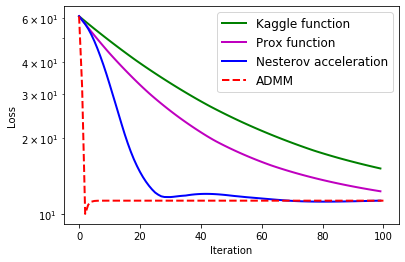

In [32]:
loss = kaggle_lasso(X,y,beta,alpha,0.005)
los_prox = proximate_grad(X,y,beta,alpha,0.0002)
nest_loss = Nesterov(X,y,beta,alpha,0.0002)
admm_los = ADMM(X,y,beta,alpha,20,max_iter = 100)

### Wczytywanie danych 

Ponownie są tutaj funkcje ale wprowadziłem w nich małe zmiany co do printownnia i dla wygody przesunąłem zeby były bliżej kiedy bawiłem sie parametrami, najważniejsze cześci pozostają bez zmian

In [9]:
def kaggle_lasso(X,y,beta,alpha,lr,max_iter = 100):

#   lr = 0.1
    loss = []
    for iter in range(max_iter):
        #print(iter,"\n")
        loss.append(loss_function(X,y,beta,alpha))
        n = X.shape[0]
        ols = -2 * X.T @ (y - X @ beta) /n
        soft = softmax_lasso(alpha*lr,beta) 
    
        grad = soft + ols
        beta = beta - lr * grad

        if iter % 50 == 0:
            print(f"Loss of the function {loss_function(X,y,beta,alpha)}")
    

    plt.semilogy(np.arange(len(loss)),loss,'g',linewidth = 2, label = 'Kaggle function')
    plt.legend(prop={'size':12})
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    
    return loss

In [10]:
def proximate_grad(X,y,beta,alpha,lr,max_iter = 100):

    #lr= 0.0001
    loss_prox = []

    for iter in range(max_iter):
        #print(iter,"\n")
        loss = loss_function(X,y,beta,alpha)
        beta = beta - lr * square_grad(X,y,beta)
        beta = softmax_lasso(alpha*lr,beta)
        loss_prox.append(loss)
    
        if iter % 10 == 0:
            print(f"Loss of the function {loss}")


    #plt.semilogy(np.arange(len(loss_prox)),loss_prox,'m',linewidth = 2, label = 'Prox function')
    plt.semilogy(np.arange(len(loss_prox)),loss_prox,'m',linewidth = 2, label = 'Prox function')
    plt.legend(prop={'size':12})
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    
    return loss_prox

In [11]:
def Nesterov(X,y,beta,alpha,lr,max_iter = 100):

    nest_loss = []

    #lr = 0.00015


    copy_beta = beta
    for iter in range(max_iter):
        
        
        loss = loss_function(X,y,beta,alpha)
        nest_loss.append(loss)
    
        beta_prev = beta
        beta = copy_beta - lr*square_grad(X,y,copy_beta)
        beta = softmax_lasso(alpha*lr,beta)
        copy_beta  = beta + iter/(iter+3) * (beta - beta_prev)
    
        if iter % 10 == 0:
            print(f"Loss of the function {loss}")
    
    

    plt.semilogy(np.arange(len(nest_loss)),nest_loss,'b',linewidth = 2, label = 'Nesterov acceleration')
    plt.legend(prop={'size':12})
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    
    return nest_loss

In [13]:
data = pd.read_csv("kc_house_data.csv")

### Wyżucamy kolumny nie mające wpłlywu na cene ja id i zipcode, czy rok wybudowania (on może mieć wpływ ale dane w latach są zwykle nieużyteczne)

In [14]:
y = np.log10(data['price'])
X = data.drop(['id', 'date',"zipcode","price",'yr_built','yr_renovated','long'], axis = 1) 
alpha = 2
beta = np.random.randint(10,size= (14,))

In [84]:
X.columns,X.shape

(Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
        'waterfront', 'view', 'condition', 'grade', 'sqft_above',
        'sqft_basement', 'lat', 'sqft_living15', 'sqft_lot15'],
       dtype='object'),
 (21613, 14))

### Widać ze niektóre wartośći są bardzo duże np sqft_lot, będziemy musieli je pomniejszyć

Jest tutaj lekki bałagan z eksploracją daltego ponizej znajduje się chunk z kodem gdzie wszytsko jest złożone do kupy.

In [85]:
X.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,sqft_living15,sqft_lot15
count,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,47.560053,1986.552492,12768.455652
std,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,0.138564,685.391304,27304.179631
min,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,47.155900,399.000000,651.000000
25%,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,47.471000,1490.000000,5100.000000
50%,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,47.571800,1840.000000,7620.000000
75%,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,47.678000,2360.000000,10083.000000
max,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,47.777600,6210.000000,871200.000000


In [15]:
X = X.apply(lambda x: np.log10(x) if (x.name == 'sqft_living') or (x.name =='sqft_lot') or (x.name =='sqft_above') or (x.name =='sqft_basement') or (x.name =='lat') or (x.name =='long') or (x.name =='sqft_living15') or (x.name =='sqft_lot15') else x)

/Users/czoppson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [87]:
X.describe()

/Users/czoppson/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,sqft_living15,sqft_lot15
count,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000
mean,3.370842,2.114757,3.279069,3.904288,1.494309,0.007542,0.234303,3.409430,7.656873,3.211554,-inf,1.677240,3.274337,3.891706
std,0.930062,0.770163,0.184491,0.391918,0.539989,0.086517,0.766318,0.650743,1.175459,0.185718,NaN,0.001266,0.142238,0.353102
min,0.000000,0.000000,2.462398,2.716003,1.000000,0.000000,0.000000,1.000000,1.000000,2.462398,-inf,1.673536,2.600973,2.813581
25%,3.000000,1.750000,3.154424,3.702431,1.000000,0.000000,0.000000,3.000000,7.000000,3.075547,NaN,1.676428,3.173186,3.707570
50%,3.000000,2.250000,3.281033,3.881841,1.500000,0.000000,0.000000,3.000000,7.000000,3.193125,NaN,1.677350,3.264818,3.881955
75%,4.000000,2.500000,3.406540,4.028896,2.000000,0.000000,0.000000,4.000000,8.000000,3.344392,2.748188e+00,1.678318,3.372912,4.003590
max,33.000000,8.000000,4.131619,6.217841,3.500000,1.000000,4.000000,5.000000,13.000000,3.973590,3.683047e+00,1.679224,3.793092,5.940118


In [16]:
X = X.fillna(0)
X["sqft_basement"] = X.sqft_basement.replace(-np.inf,0)
X.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,sqft_living15,sqft_lot15
count,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,3.370842,2.114757,3.279069,3.904288,1.494309,0.007542,0.234303,3.409430,7.656873,3.211554,1.098107,1.677240,3.274337,3.891706
std,0.930062,0.770163,0.184491,0.391918,0.539989,0.086517,0.766318,0.650743,1.175459,0.185718,1.376615,0.001266,0.142238,0.353102
min,0.000000,0.000000,2.462398,2.716003,1.000000,0.000000,0.000000,1.000000,1.000000,2.462398,0.000000,1.673536,2.600973,2.813581
25%,3.000000,1.750000,3.154424,3.702431,1.000000,0.000000,0.000000,3.000000,7.000000,3.075547,0.000000,1.676428,3.173186,3.707570
50%,3.000000,2.250000,3.281033,3.881841,1.500000,0.000000,0.000000,3.000000,7.000000,3.193125,0.000000,1.677350,3.264818,3.881955
75%,4.000000,2.500000,3.406540,4.028896,2.000000,0.000000,0.000000,4.000000,8.000000,3.344392,2.748188,1.678318,3.372912,4.003590
max,33.000000,8.000000,4.131619,6.217841,3.500000,1.000000,4.000000,5.000000,13.000000,3.973590,3.683047,1.679224,3.793092,5.940118


## zdecydowałem się zlogarymować największe wartosći (podstawa 2)

In [185]:
data = pd.read_csv("kc_house_data.csv")
y = np.log2(data['price'])
X = data.drop(['id', 'date',"zipcode","price",'yr_built','yr_renovated','long'], axis = 1) 
alpha = 2
X.insert(loc=0, column='intercept', value=np.ones_like(X.iloc[:,0]))
beta = np.random.randint(10,size= (15,))
X = X.apply(lambda x: np.log2(x) if (x.name == 'sqft_living') or (x.name =='sqft_lot') or (x.name =='sqft_above') or (x.name =='sqft_basement') or (x.name =='lat') or (x.name =='long') or (x.name =='sqft_living15') or (x.name =='sqft_lot15') else x)
X = X.fillna(0)
X["sqft_basement"] = X.sqft_basement.replace(-np.inf,0)

/Users/czoppson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log2
  import sys


### Poszczególne wylicznia można podejżeć, alpha to lambda w naszym lasso ale niestety python nie pozmwala na nazywanie tak zmiennych bo mają swoja wbudowaną użyteczność

Loss of the function 74228.50601185921
Loss of the function 1892.8332782738962
Loss of the function 426.8062993371294
Loss of the function 373.10099003287024
Loss of the function 349.5268190137375
Loss of the function 328.4389220173422
Loss of the function 309.12525493592545
Loss of the function 291.4244475434772
Loss of the function 275.1988428977715
Loss of the function 260.3227759467429
Loss of the function 246.68133307946934
Loss of the function 234.16942457668574
Loss of the function 222.6909431796809
Loss of the function 212.15799521771288
Loss of the function 202.49019764396166
Loss of the function 193.61403528127926
Loss of the function 185.4622731125301
Loss of the function 177.97341889908878
Loss of the function 171.10352168250165
Loss of the function 164.8265039879122
Loss of the function 159.05645649055964
Loss of the function 153.75039509887722
Loss of the function 148.8690058934214
Loss of the function 144.37633109158577
Loss of the function 140.2394819405418
Loss of the 

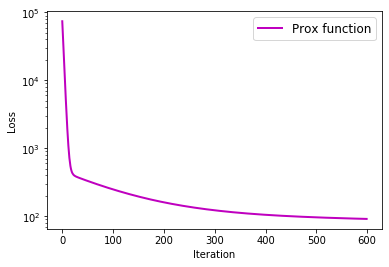

In [49]:
loss_prox = proximate_grad(X,y,beta,alpha,0.00000001,max_iter = 600)

Loss of the function 74228.50601185921
Loss of the function 511.1234393655867
Loss of the function 304.5527356235796
Loss of the function 199.51462899885018
Loss of the function 130.4050871167346
Loss of the function 98.93583242989229
Loss of the function 92.41059228832694
Loss of the function 91.82181207349916
Loss of the function 87.87555527432701
Loss of the function 81.15061416957475
Loss of the function 75.06084587975242
Loss of the function 70.94223792810638
Loss of the function 68.07437765912428
Loss of the function 65.07020660393727
Loss of the function 61.86228651776299
Loss of the function 59.428183024612046
Loss of the function 57.65280324727287
Loss of the function 56.081620747812494
Loss of the function 54.40390997545745
Loss of the function 52.91640100217976
Loss of the function 51.741785467088555
Loss of the function 50.78614329473688
Loss of the function 49.84600933707758
Loss of the function 48.72987160415919
Loss of the function 47.519220805417476
Loss of the function

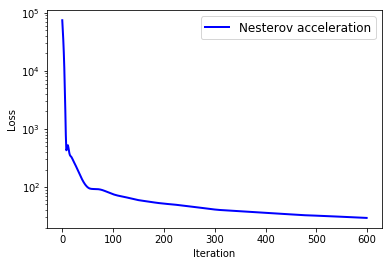

In [50]:
nest_loss = Nesterov(X,y,beta,alpha,0.00000001,max_iter = 600)

Loss of the function 354.92109553197173
Loss of the function 77.14810588922019
Loss of the function 75.10669190214126
Loss of the function 73.24487811803549
Loss of the function 27.646640792578285
Loss of the function 17.51228968472926
Loss of the function 6.892833203136669
Loss of the function 5.836551794673458
Loss of the function 6.477085513484386
Loss of the function 6.742480554629003
Loss of the function 6.741690250594599
Loss of the function 6.7407793312530355
Loss of the function 6.739762666288175
Loss of the function 6.73865036073224
Loss of the function 6.737450063633373
Loss of the function 6.736168094768824
Loss of the function 6.734810002856953
Loss of the function 6.733380844498267
Loss of the function 6.389101112092054
Loss of the function 6.39035974862879
Loss of the function 6.3914778308622395
Loss of the function 6.392561341374467
Loss of the function 6.3936105940298855
Loss of the function 6.394626547577573
Loss of the function 6.395610442983755
Loss of the function 6

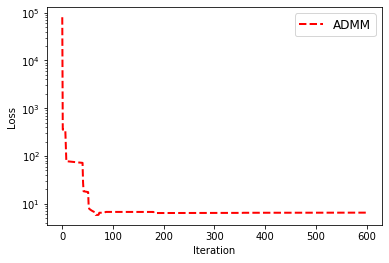

In [68]:
admm_los = ADMM(X,y,beta,alpha,10,max_iter = 600)

### Porównanie prędkości algorytmów dla dancyh i tych samych parametrów kary i iteracji

Text(0, 0.5, 'Loss')

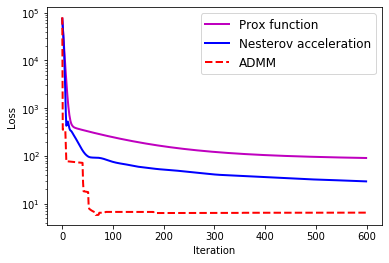

In [69]:
    plt.semilogy(np.arange(len(loss_prox)),loss_prox,'m',linewidth = 2, label = 'Prox function')
    plt.semilogy(np.arange(len(nest_loss)),nest_loss,'b',linewidth = 2, label = 'Nesterov acceleration')
    plt.semilogy(np.arange(len(admm_los)),admm_los,'r--',linewidth = 2, label = 'ADMM')
    plt.legend(prop={'size':12})
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

# Cross validation

Chce znaleść najlepsze alpha(czyli $\lambda$ w lasso) wieć podzeliłem dane na zbiór treningowy walidacyjny i testowy.
Na treningowym szukam optymalej $\beta$ i sprawdzam jak model działa na validacyjnym. Na końcu zachowuje paramter który najlepiej sprawdził się na zbioże walidacyjnym. W ramach ciekawości sprawdzam też jak działa na testowym. Wiem że tego się tak nie robi ale byłem ciekaw czy zeczywiście walidacja zadziała prawidłowo, zdaję sobie sprawę, że generalnie nie wolno stosować takiej metody.

In [7]:
from sklearn.model_selection import train_test_split

In [32]:
def ADMM(X,y,beta,alpha,rho,max_iter = 10):
    
    m,n = X.shape

    #w,v  = np.linalg.eig(X.T @ X)
    u = np.array([0]*n)
    zhat = np.array([0]*n)

# coeficients 
    #alpha = 0.5
    #rho = 0.1 #1/abs(w).max()


#precomputing

    left_beta = np.linalg.inv(X.T @ X + rho*np.identity(n))
    #left_beta.shape

    Xty = X.T @ y 
    #Xty.shape

    admm_loss = []
    admm_loss.append(loss_function(X,y,beta,alpha))
    for i in range(max_iter):
        
        loss = loss_function(X,y,zhat,alpha)
   #     if i % 10 == 0:
   #         print(f"Loss of the function {loss}")
        admm_loss.append(loss)

        "x minimisation step via posterier OLS"
        beta = left_beta @ (Xty + rho*(zhat - u))

        "z minimisation via soft-thresholding"
        zhat =softmax_lasso(alpha/rho,beta + u )#Sthresh(beta + u, alpha*rho)
       # softmax_lasso(alpha/rho,beta + u ) #Sthresh(beta + u, alpha/rho)

        "mulitplier update"
        u = u + beta - zhat
        



   # plt.semilogy(np.arange(len(admm_loss)),admm_loss,'r--',linewidth = 2, label = 'ADMM')
   # plt.legend(prop={'size':12})
   # plt.xlabel('Iteration')
   # plt.ylabel('Loss')
    
    return admm_loss, zhat

Loss of the function 354.92109553197173
Loss of the function 77.14810588922019
Loss of the function 75.10669190214126
Loss of the function 73.24487811803549
Loss of the function 27.646640792578285
Loss of the function 17.51228968472926
Loss of the function 6.892833203136669
Loss of the function 5.836551794673458
Loss of the function 6.477085513484386
Loss of the function 6.742480554629003
Loss of the function 6.741690250594599
Loss of the function 6.7407793312530355
Loss of the function 6.739762666288175
Loss of the function 6.73865036073224
Loss of the function 6.737450063633373
Loss of the function 6.736168094768824
Loss of the function 6.734810002856953
Loss of the function 6.733380844498267
Loss of the function 6.389101112092054
Loss of the function 6.39035974862879
Loss of the function 6.3914778308622395
Loss of the function 6.392561341374467
Loss of the function 6.3936105940298855
Loss of the function 6.394626547577573
Loss of the function 6.395610442983755
Loss of the function 6

array([ 0.        , -0.02233746, -0.        ,  0.09858094, -0.        ,
        0.0042711 ,  0.        ,  0.12187619,  0.13399655,  0.25935667,
        0.23042919,  0.02777468,  1.95067843,  0.24203264, -0.05014927])

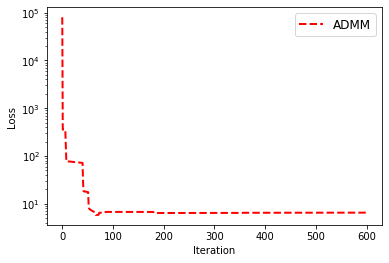

array([ 0.        , -0.02233746, -0.        ,  0.09858094, -0.        ,
        0.0042711 ,  0.        ,  0.12187619,  0.13399655,  0.25935667,
        0.23042919,  0.02777468,  1.95067843,  0.24203264, -0.05014927])

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [74]:
X_test.shape, X_train.shape,X_test.shape[0]/X_train.shape[0]

((4323, 15), (17290, 15), 0.2500289184499711)

In [187]:
X_train , X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=2020)

In [77]:
X_valid.shape

(4323, 15)

In [87]:
np.arange(0,10+1e-3,0.1)

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. ])

In [56]:
def cross_validation(X_treningowy,X_validacyjny,X_testowy,y_treningowy,y_validacyjny,y_testowy):
    beta_optimum = 0 
    loss_optimum = 100000
    beta = np.random.randint(10,size= (15,))
    #alpha_opt = 0
    loss = []
    
    for alpha in np.arange(0.5,5+1e-3,0.1):
        
        admm_loss,beta_est = ADMM(X_treningowy,y_treningowy,beta,alpha,5,max_iter = 100)#20, 100
        loss_est = loss_function(X_validacyjny,y_validacyjny,beta_est,alpha)
        loss.append(loss_est)
        print(f"Dla alpha = {round(alpha,2)},validation loss = {loss_est}, test loss = {round(loss_function(X_testowy,y_testowy,beta_est,alpha),2)}")
        
        if loss_est < loss_optimum:
            loss_optimum = loss_est
            beta_optimum = beta_est
            alpha_opt = alpha
            m = f"New optimal alpha {round(alpha,2)} where validation loss is {round(loss_est,2)}"
            print('{0}\n{1}\n{0}'.format('-' * len(m), m))
        
        plt.scatter(np.arange(len(loss)),loss,label = "Validation_loss")
        plt.xlabel('Alpha_value')
        plt.ylabel('Loss')
              
    return beta_optimum

Dla alpha = 0.5,validation loss = 7.638542508592005, test loss = 7.64
---------------------------------------------------
New optimal alpha 0.5 where validation loss is 7.64
---------------------------------------------------
Dla alpha = 0.6,validation loss = 8.76989705996164, test loss = 8.76
Dla alpha = 0.7,validation loss = 9.803179580838092, test loss = 9.79
Dla alpha = 0.8,validation loss = 10.762415083602882, test loss = 10.77
Dla alpha = 0.9,validation loss = 11.759155006571184, test loss = 11.74
Dla alpha = 1.0,validation loss = 11.89422292520918, test loss = 11.89
Dla alpha = 1.1,validation loss = 12.275722431586052, test loss = 12.27
Dla alpha = 1.2,validation loss = 12.469731942352755, test loss = 12.47
Dla alpha = 1.3,validation loss = 5.093967923040121, test loss = 5.1
---------------------------------------------------
New optimal alpha 1.3 where validation loss is 5.09
---------------------------------------------------
Dla alpha = 1.4,validation loss = 5.462307784507138

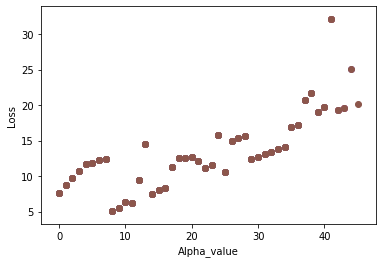

In [189]:
super_beta = cross_validation(X_train,X_valid,X_test,y_train,y_valid,y_test)# rho = 20

In [168]:
np.sum((y_test - X_test @ super_beta)**2)

1150.7865844246282

# Porównanie wychodzi całkiem nieźle, niestety poprzez wcześniejsze przekształcenia podane są jako potegi 2. Te potęgi są na pzoiomie 18 - 20 więc mała różnica w estymowanej potędze przekłada się na dużą różnicę w cenie.

In [190]:
y_est = X_test @ super_beta
final_dict = {"Price":y_test,"Esitmated_price":y_est,"Real Price":2**y_test,"Estim_real": 2**y_est}
pd.DataFrame(final_dict).head()

,Price,Esitmated_price,Real Price,Estim_real
21568,20.697103,19.515946,1700000.0,749695.887578
3040,19.542790,19.232977,763776.0,616173.392805
198,18.747144,18.284516,440000.0,319291.806559
16456,18.842301,18.449270,470000.0,357918.082771
19502,18.763446,18.702836,445000.0,426692.056697


## Tutaj po prostu podziele największe parametry przez 1000.

In [13]:
data = pd.read_csv("kc_house_data.csv")
y = data['price']/1000
X = data.drop(['id', 'date',"zipcode","price",'yr_built','yr_renovated','long'], axis = 1) 
alpha = 2
X.insert(loc=0, column='intercept', value=np.ones_like(X.iloc[:,0]))
beta = np.random.randint(10,size= (15,))
X = X.apply(lambda x: x/1000 if (x.name == 'sqft_living') or (x.name =='sqft_lot') or (x.name =='sqft_above') or (x.name =='sqft_basement') or (x.name =='lat') or (x.name =='long') or (x.name =='sqft_living15') or (x.name =='sqft_lot15') else x)
X = X.fillna(0)
X["sqft_basement"] = X.sqft_basement.replace(-np.inf,0)

In [14]:
X.describe()

,intercept,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,sqft_living15,sqft_lot15
count,21613.0,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,1.0,3.370842,2.114757,2.079900,15.106968,1.494309,0.007542,0.234303,3.409430,7.656873,1.788391,0.291509,0.047560,1.986552,12.768456
std,0.0,0.930062,0.770163,0.918441,41.420512,0.539989,0.086517,0.766318,0.650743,1.175459,0.828091,0.442575,0.000139,0.685391,27.304180
min,1.0,0.000000,0.000000,0.290000,0.520000,1.000000,0.000000,0.000000,1.000000,1.000000,0.290000,0.000000,0.047156,0.399000,0.651000
25%,1.0,3.000000,1.750000,1.427000,5.040000,1.000000,0.000000,0.000000,3.000000,7.000000,1.190000,0.000000,0.047471,1.490000,5.100000
50%,1.0,3.000000,2.250000,1.910000,7.618000,1.500000,0.000000,0.000000,3.000000,7.000000,1.560000,0.000000,0.047572,1.840000,7.620000
75%,1.0,4.000000,2.500000,2.550000,10.688000,2.000000,0.000000,0.000000,4.000000,8.000000,2.210000,0.560000,0.047678,2.360000,10.083000
max,1.0,33.000000,8.000000,13.540000,1651.359000,3.500000,1.000000,4.000000,5.000000,13.000000,9.410000,4.820000,0.047778,6.210000,871.200000


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
X_train , X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=2020)

Dla alpha = 0.5,validation loss = 59625.306348830985, test loss = 52332.2
-------------------------------------------------------
New optimal alpha 0.5 where validation loss is 59625.31
-------------------------------------------------------
Dla alpha = 0.6,validation loss = 60191.110659173704, test loss = 52901.71
Dla alpha = 0.7,validation loss = 60697.47436840749, test loss = 53408.07
Dla alpha = 0.8,validation loss = 61144.35360937751, test loss = 53851.23
Dla alpha = 0.9,validation loss = 61649.57825338081, test loss = 54356.45
Dla alpha = 1.0,validation loss = 62154.24069502853, test loss = 54861.11
Dla alpha = 1.1,validation loss = 62658.34089095444, test loss = 55365.2
Dla alpha = 1.2,validation loss = 63161.878867568805, test loss = 55868.74
Dla alpha = 1.3,validation loss = 63883.090352995925, test loss = 56563.84
Dla alpha = 1.4,validation loss = 64385.53193085795, test loss = 57066.28
Dla alpha = 1.5,validation loss = 64669.11944298369, test loss = 57375.96
Dla alpha = 1.6,

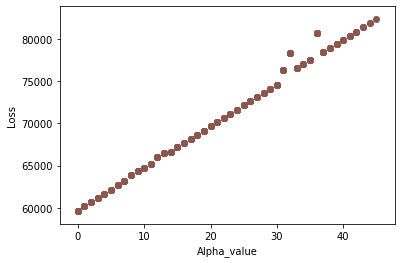

In [57]:
super_beta = cross_validation(X_train,X_valid,X_test,y_train,y_valid,y_test)

In [42]:
y_est = X_test @ super_beta
final_dict = {"Price":y_test,"Esitmated_price":y_est,"Real Price":y_test*1000,"Estim_real": y_est*1000}
pd.DataFrame(final_dict).head()

,Price,Esitmated_price,Real Price,Estim_real
21568,1700.000,1022.304474,1700000.0,1.022304e+06
3040,763.776,731.534638,763776.0,7.315346e+05
198,440.000,367.544572,440000.0,3.675446e+05
16456,470.000,426.558042,470000.0,4.265580e+05
19502,445.000,508.149987,445000.0,5.081500e+05


In [60]:
super_beta[abs(super_beta)< 1] = 0 
super_beta

array([-8.58278899e+02, -3.31661661e+01, -1.37525439e+01,  1.30112824e+02,
        0.00000000e+00, -2.58848211e+00,  5.94469043e+02,  6.40203217e+01,
        5.38960327e+01,  1.03684439e+02,  4.28991961e+01,  7.72136280e+01,
        3.09196769e+03,  1.86988447e+01,  0.00000000e+00])

Problem który sie tutaj pojawia to fakt że nasz model niechętnie zeruje współczynniki. Kara za niedposaowanie jest dużo bardziej znacząca niż kara za rozmiar współczynników więc nie mamy tyle zer co poprzednio.

## Wykonał i opracował Szymon Czop 